In [1]:
from ipypb import track as tqdm
import torch
import astar
import diffplan
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numba
import random
%load_ext autoreload
%autoreload 2
%matplotlib inline

eps = torch.finfo().eps

# 4 rooms - BFS

CPU times: user 9.08 s, sys: 73.4 ms, total: 9.16 s
Wall time: 9.34 s
seed 808431572
19 58.978355407714844
39 57.7877197265625
59 54.794395446777344
79 52.72170639038086
99 52.46784973144531
99 Reset optimizer state
119 52.421817779541016
139 52.41806411743164
159 52.417320251464844
179 52.41700744628906
199 52.41683578491211
199 Reset optimizer state
219 52.41637420654297
239 52.416481018066406
CPU times: user 12min 51s, sys: 15.9 s, total: 13min 7s
Wall time: 13min 34s


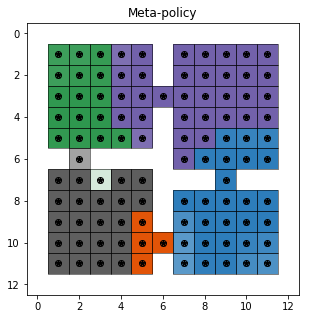

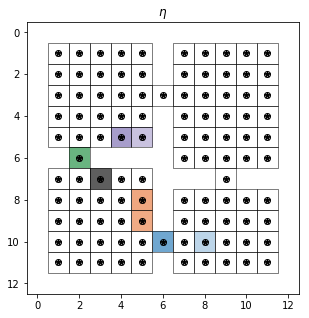

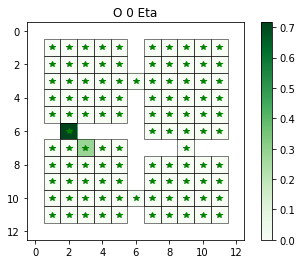

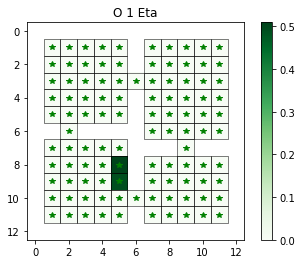

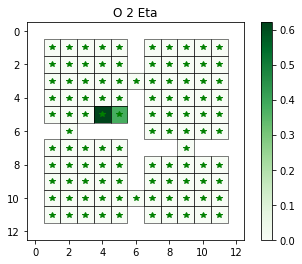

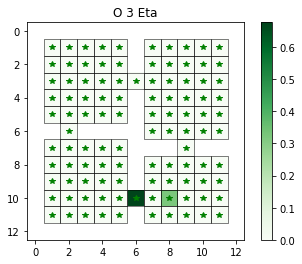

In [39]:

env = diffplan.Grid('''
xxxxxxxxxxxxx
x     x     x
x     x     x
x           x
x     x     x
x     x     x
xx xxxx     x
x     xxx xxx
x     x     x
x     x     x
x           x
x     x     x
xxxxxxxxxxxxx
''')
env.start_states = env.states
env.goal_set = set(env.states_features)
%time D = diffplan.compute_distance_matrix(env)
BFS = diffplan.compute_bfs_matrix(env, D)
%time d=diffplan.option_learner_grad(env, search_cost=D+BFS, lr=0.1, reset=100, grad_steps=250, progress=20, goal_uniform_random=True, add_goal_options=True, num_options=4)

# 4 rooms - A*

In [42]:
env = diffplan.Grid('''
xxxxxxxxxxxxx
x     x     x
x     x     x
x           x
x     x     x
x     x     x
xx xxxx     x
x     xxx xxx
x     x     x
x     x     x
x           x
x     x     x
xxxxxxxxxxxxx
''')
env.start_states = env.states
env.goal_set = set(env.states_features)

h = astar.compute_manhattan_heuristic(env)
%time astar_dist, astar_cost = astar.compute_astar_matrix(env, h, tqdm=tqdm, samples=20)

 [████████████████████████████████████████████████████████████] 104/104 [02:52<00:02, 1.66s/it]

CPU times: user 1min 28s, sys: 1min 14s, total: 2min 43s
Wall time: 2min 52s


In [ ]:
%time d=diffplan.option_learner_grad(env, search_cost=astar_dist+astar_cost, lr=0.1, reset=100, grad_steps=250, progress=20, goal_uniform_random=True, add_goal_options=True, num_options=4)

seed 1053638167
19 19.32801628112793
39 18.157825469970703
59 17.096302032470703
79 16.742984771728516
99 16.519432067871094
99 Reset optimizer state


# mark 3-room - A*

In [40]:
env = diffplan.Grid('''
xxxxxxxxx
x       x
x   xxx x
xG  x   x
xxxxx   x
x   x xxx
x   x   x
xS      x
xxxxxxxxx
''')
h = astar.compute_manhattan_heuristic(env)
astar_dist, astar_cost = astar.compute_astar_matrix(env, h, tqdm=tqdm, samples=20)

 [████████████████████████████████████████████████████████████] 37/37 [00:17<00:00, 0.47s/it]

seed 1038289416
19 50.60833740234375
39 48.38460159301758
59 46.45713424682617
79 45.296722412109375
99 44.423866271972656
99 Reset optimizer state
119 43.414119720458984
139 43.24078369140625
159 43.23030090332031
179 43.227806091308594
199 43.226497650146484
199 Reset optimizer state
219 43.221553802490234
239 43.221351623535156
259 43.221309661865234
279 43.22129440307617
299 43.2213020324707
299 Reset optimizer state
319 43.22125244140625
339 43.22124481201172
CPU times: user 5.53 s, sys: 85.8 ms, total: 5.62 s
Wall time: 5.64 s


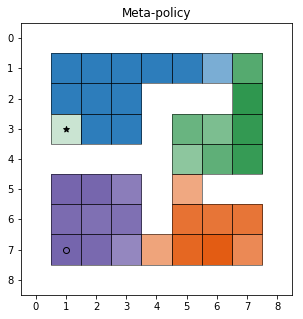

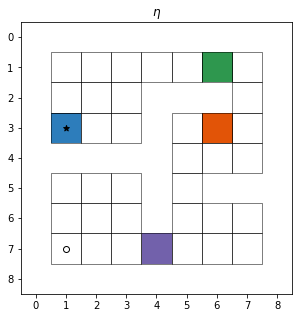

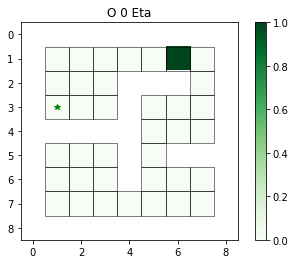

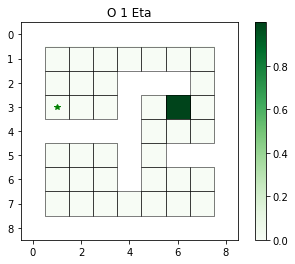

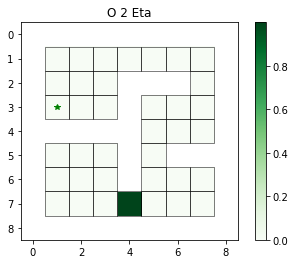

In [38]:
%time d=diffplan.option_learner_grad(env, search_cost=astar_dist+astar_cost, lr=0.1, reset=100, grad_steps=350, progress=20, goal_uniform_random=True, num_options=3, add_goal_options=True)
